## 参考文献
* [岩波データサイエンスvol.3のデータで遊ぼう](https://rstudio-pubs-static.s3.amazonaws.com/192092_6a8bac32eac24d7ca3a4791a80e7f3d3.html)
>★★★
* [Harvard Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)
>★★
> * [pdf](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2019/11/ci_hernanrobins_10nov19.pdf)
> * [github(python)](https://github.com/jrfiedler/causal_inference_python_code)
* https://www.randpy.tokyo/entry/python_propensity_score
> ★★★
> * Pythonによる実装
> * 傾向スコアでのマッチングおよび、IPW推定量まで
* https://www.slideshare.net/shuyo/observational-study-causality-52737410?qid=c202bc91-24d0-46e9-96e3-d9238e1e43bb&v=&b=&from_search=3
> ★★
>* 星野本1・2章の振り返り＆3章まとめ
>* 本よりは簡潔で分かりやすいが、数式も割と追っている
* http://tomoshige-n.hatenablog.com/entry/2016/06/19/033252
>★★
>* 岩波DSvol3の著者のうち1名のブログ
>* IPW推定量のイメージが少しつかめる
* https://sites.google.com/site/iwanamidatascience/vol-3/vol3-ingasuiron
>★
>* 岩波DSvol3の各論の補足資料
* https://speakerdeck.com/tomoshige_n/causal-inference-and-data-analysis
>★★★
>* 傾向スコア使用時の実務的な注意点など
>* 因果推論とは究極的に、「処置と結果変数に影響する変数の分布をすべて」処置群と対称群で等しくすればよい。（P.19）
>* 2つの群の分布を釣り合わせているというのは、処置変数に影響する変数／潜在結果変数に与える影響が、2つの群で同じ分布となること（P.23）
>* Bootstrap法でばらつきを考えるべき
>* 推定値・BSサンプルの平均・推定分散・BSサンプルの分散・95%信頼区間・BS95%信頼区間、の6つは絶対に示した方が良い
* https://www.slideshare.net/takehikoihayashi/propensity-score-analysis-seminar-japanese
>★★
>* ・1番とっつきやすい資料
* https://www.slideshare.net/okumurayasuyuki/ss-43780294?next_slideshow=1
>★★
>* 傾向スコアの利用法が詳しい

## 準備

In [1]:
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
df = pd.read_csv('q_data_x.csv')
df.shape
df.head()

(10000, 35)

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,749.5,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,49.344942,0,0


## 分析1：岩波DS3解説の再現

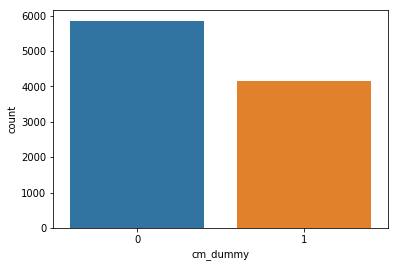

In [6]:
sns.countplot(x='cm_dummy', data=df)

### 平均値の比較
* アプリ利用秒数と利用回数の平均値はCM接触群の方が小さい

In [7]:
agg_cols = [
    "gamedummy",
    "gamecount",
    "gamesecond"
]
df.groupby("cm_dummy")[agg_cols].mean()

,gamedummy,gamecount,gamesecond
cm_dummy,,,
0,0.073087,10.048497,3107.706455
1,0.075290,8.563948,2478.065878


### セレクションバイアス
* 居住地、性別、年齢、職業、TV試聴時間などがかなり異なる

In [8]:
pd.merge(df[df.cm_dummy==1].describe().T[['mean','std']],
         df[df.cm_dummy==0].describe().T[['mean','std']],
         left_index=True,
         right_index=True, 
         how='left',
         suffixes=['_cm_dummy_0', '_cm_dummy_1'])

,mean_cm_dummy_0,std_cm_dummy_0,mean_cm_dummy_1,std_cm_dummy_1
cm_dummy,1.000000,0.000000,0.000000,0.000000
gamedummy,0.075290,0.263890,0.073087,0.260302
area_kanto,0.131033,0.337477,0.063012,0.243006
area_keihan,0.701255,0.457763,0.509051,0.499961
area_tokai,0.093147,0.290673,0.124488,0.330165
area_keihanshin,0.074566,0.262721,0.303449,0.459787
age,41.767133,10.148360,40.187158,10.636461
sex,0.596766,0.490606,0.671107,0.469851
marry_dummy,0.670367,0.470137,0.630464,0.482720
job_dummy1,0.517616,0.499750,0.600581,0.489821


### 平均処置効果の推定
* 平均処置効果：ATE(Average Treatment Effect)
* 処置群での平均処置効果：ATT(Average Treatment effect on the Treated)

In [13]:
import statsmodels.api as sm
from statsmodels.tools import add_constant

In [9]:
x_cols=[
    'TVwatch_day',
    'age',
    'sex',
    'marry_dummy',
    'child_dummy',
    'inc',
    'pmoney',
    'area_kanto',
    'area_tokai',
    'area_keihanshin',
    'job_dummy1',
    'job_dummy2',
    'job_dummy3',
    'job_dummy4',
    'job_dummy5',
    'job_dummy6',
    'job_dummy7',
    'fam_str_dummy1',
    'fam_str_dummy2',
    'fam_str_dummy3',
    'fam_str_dummy4',
    #'T',
    #'F1',
    #'F2',
    #'F3',
    #'M1',
    #'M2',
    #'M3',
]

In [14]:
ps_model = sm.Logit(df.cm_dummy, add_constant(df[x_cols])).fit()
ps_model.summary2()

Optimization terminated successfully.
         Current function value: 0.542117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.201     
Dependent Variable: cm_dummy         AIC:              10886.3417
Date:               2019-11-13 15:34 BIC:              11044.9692
No. Observations:   10000            Log-Likelihood:   -5421.2   
Df Model:           21               LL-Null:          -6784.2   
Df Residuals:       9978             LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.7709   0.2615  -6.7728 0.0000 -2.2833 -1.2584
TVwatch_day       0.0001   0.0000  31.9917 0.0000  0.0001  0.0001
age              -0.0026   0.0029  -0.8871 0.3750 -0.0084  0.0032
sex               0.0006   0.0647   0.0092 0.9927 -0.1262  0.1273
marry_dummy      -0.0781   0.0856  -0.9134 0.3610 -0.2458  0.0895
child_dummy       0.3142   0.0743   4.2269 0.0000  0.1685  0.4599
inc              -0.0005   0.0002  -2.9190 0.0035 -0.0008 -0.0002
pmoney            0.0119   0.0077   1.5434 0.1227 -0.0032  0.0271
area_kanto        0.4050   0.0790   5.1239 0.0000  0.2501  0.5599
area_tokai       -0.7233   0.0765  -9.4490 0.0000 -0.8733 -0.5732
area_keihanshin  -2.0420   0.0756 -27.0074 0.0000 -2.1902 -1.8938
job_dummy1        0.1752   0.1562   1.1219 0.2619 -0.1309  0.4814
job_dummy2        0.1651   0.1677   0.9842 0.3250 -0.1637  0.4938
job_dummy3        0.5399   0.1604   3.3659 0.0008  0.2255  0.8543
job_dummy4        0.3604   0.2433   1.4811 0.1386 -0.1165  0.8372
job_dummy5        0.6414   0.1520   4.2193 0.0000  0.3435  0.9393
job_dummy6        0.2848   0.1581   1.8010 0.0717 -0.0251  0.5947
job_dummy7        0.1540   0.1834   0.8394 0.4013 -0.2056  0.5135
fam_str_dummy1    0.7640   0.2045   3.7359 0.0002  0.3632  1.1648
fam_str_dummy2    1.0033   0.2176   4.6118 0.0000  0.5769  1.4297
fam_str_dummy3    0.6137   0.2021   3.0373 0.0024  0.2177  1.0098
fam_str_dummy4    0.1799   0.2216   0.8121 0.4167 -0.2543  0.6142
=================================================================

"""

In [17]:
# モデルの予測値の確認
df['ps'] = ps_model.predict(add_constant(df[x_cols]))
df['ps'].describe()

count    10000.000000
mean         0.414400
std          0.243460
min          0.020762
25%          0.247706
50%          0.373040
75%          0.563423
max          0.998033
Name: ps, dtype: float64

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df.cm_dummy, df.ps)

0.7917028470947529

In [19]:
#★
#傾向スコアの逆数の重み
df['ipw_ate'] = np.where(df.cm_dummy==1,
                         1 / df.ps,
                         1 / (1 - df.ps))
df['ipw_att'] = np.where(df.cm_dummy==1,
                         1,
                         df.ps / (1 - df.ps))
ate_models = [
    sm.WLS(df.gamedummy, pd.get_dummies(df.cm_dummy), weights=df.ipw_ate).fit(),
    sm.WLS(df.gamecount, pd.get_dummies(df.cm_dummy), weights=df.ipw_ate).fit(),
    sm.WLS(df.gamesecond, pd.get_dummies(df.cm_dummy), weights=df.ipw_ate).fit()
]
att_models = [
    sm.WLS(df.gamedummy, pd.get_dummies(df.cm_dummy), weights=df.ipw_att).fit(),
    sm.WLS(df.gamecount, pd.get_dummies(df.cm_dummy), weights=df.ipw_att).fit(),
    sm.WLS(df.gamesecond, pd.get_dummies(df.cm_dummy), weights=df.ipw_att).fit()
]                         

In [20]:
df_result = pd.DataFrame(index=[
    'ATE_gamedummy', 'ATE_gamecount', 'ATE_gamesecond',
    'ATT_gamedummy', 'ATT_gamecount', 'ATT_gamesecond'
],columns=[
    'cm_dummy_1', 'cm_dummy_0', 'causal_effect'
])
for (i, model) in enumerate(ate_models + att_models):
    df_result.iloc[i, 0] = model.params[1]
    df_result.iloc[i, 1] = model.params[0]
df_result.causal_effect = df_result.cm_dummy_1 - df_result.cm_dummy_0
df_result

,cm_dummy_1,cm_dummy_0,causal_effect
ATE_gamedummy,0.0943644,0.0624071,0.0319572
ATE_gamecount,13.6364,8.31669,5.31967
ATE_gamesecond,4143.33,2639.41,1503.92
ATT_gamedummy,0.0752896,0.0496548,0.0256348
ATT_gamecount,8.56395,6.2489,2.31505
ATT_gamesecond,2478.07,2080.27,397.8


In [21]:
#ATE
w1 = df.cm_dummy / df.ps
w0 = (1 - df.cm_dummy) / (1 - df.ps)
ate_value = (w1 * df['gamedummy']).sum() / w1.sum() - (w0 * df['gamedummy']).sum() / w0.sum()
print(f'ATE:{ate_value:.4f}')
#ATT
att_value = (df['cm_dummy']*df['gamedummy']).sum() / df['cm_dummy'].sum() - (w0*df.ps*df['gamedummy']).sum() / (w0*df.ps).sum()
print(f'ATT:{att_value:.4f}')

ATE:0.0320
ATT:0.0256


### 調整効果の推定
* 飛ばす

## 分析2：本に載っていないことを試す

### 傾向スコアによる層別解析

In [31]:
y_list = ['gamedummy', 'gamecount', 'gamesecond']
strata_list = [5, 10, 20]
df_strata = pd.DataFrame(index=['ate_'+str(i) for i in strata_list],
                         columns=y_list)

for y in y_list:
    for strata in strata_list:
        col_name = 'strata' + str(strata)
        df[col_name] = pd.qcut(df.ps, strata)
        df_agg = pd.pivot_table(df, values=y, index=col_name,
                                columns='cm_dummy', aggfunc='mean')
        df_strata.loc['ate_'+str(strata), y] \
            = (df_agg[1] - df_agg[0]).mean()
df_strata

,gamedummy,gamecount,gamesecond
ate_5,0.0218066,1.4988,68.2629
ate_10,0.0303475,4.56372,1317.08
ate_20,0.0556413,16.0481,5482.29


* 層別解析とサブグループ解析は異なる
* 層別解析では、最終的に各層での結果を統合する
> http://triadsou.hatenablog.com/entry/20070719/1239383308

### 傾向スコアによるマッチング

### 傾向スコアによるカーネルマッチング

### 傾向スコアをロジスティック回帰以外の方法で推定する